In [3]:
%matplotlib inline

# include modules to the path
import sys, os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'session'))

import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from session.utils import get_sessions_list

## Occupancy in L - D - L'

In [5]:
# session paths
source = '/home/sobolev/nevermind/Andrey/data'
animal = '006865'

# single sessions
sessions = ['006865_hippoSIT_2021-12-14_16-25-01']

# or list of sessions
#sessions = get_sessions_list(os.path.join(source, animal), animal)[55:]

In [6]:
sessions

['006865_hippoSIT_2021-12-14_16-25-01']

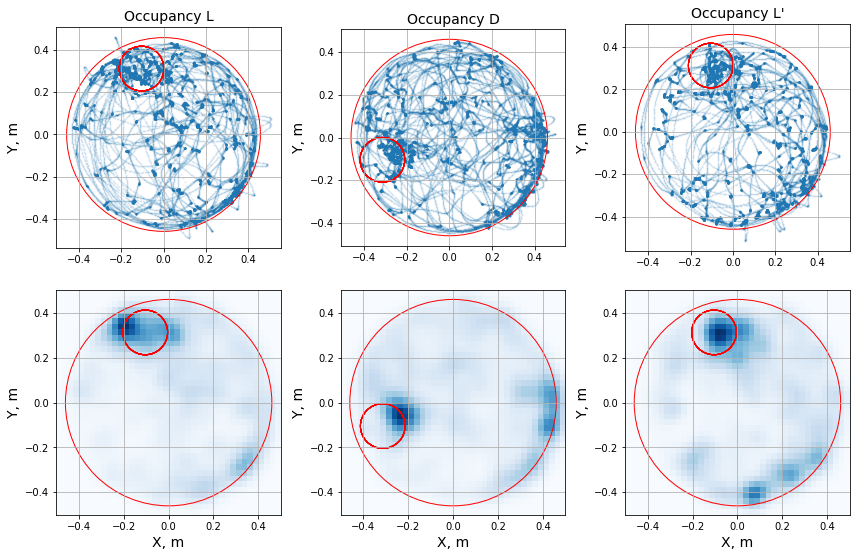

In [7]:
for session in sessions:
    s_path = os.path.join(source, animal, session)
    h5name = os.path.join(s_path, session + '.h5')
    jsname = os.path.join(s_path, session + '.json')

    # loading data
    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
        trial_idxs = np.array(f['processed']['trial_idxs'])  # idx start, idx end, X, Y, R, trial result (idx to tl)

    # loading session configuration
    with open(jsname, 'r') as f:
        cfg = json.load(f)

    arena_r = cfg['position']['floor_r_in_meters']
    timepoints = cfg['experiment']['timepoints']
    s_duration = cfg['experiment']['session_duration']

    periods = [[0, timepoints[0]], [timepoints[1], timepoints[2]], [timepoints[3], s_duration]]

    # plot
    fig = plt.figure(figsize=(12, 8))
    titles = ['L', 'D', 'L\'']

    for i, period in enumerate(periods):
        sel = tl[(tl[:, 0] > period[0]) & (tl[:, 0] < period[1])]
        sel_trial_idxs = []
        for t_idx_rec in trial_idxs:
            if tl[int(t_idx_rec[0])][0] >= period[0] and tl[int(t_idx_rec[0])][0] < period[1]:
                sel_trial_idxs.append(t_idx_rec)
        sel_trial_idxs = np.array(sel_trial_idxs)

        # trajectory and islands
        ax = fig.add_subplot(2, 3, i+1)
        ax.scatter(sel[:, 1], sel[:, 2], s=1, alpha=0.1)  # positions
        scat = ax.scatter(sel_trial_idxs[:, 2], sel_trial_idxs[:, 3], s=2000, facecolors='none', edgecolors='r')  # islands, radius approx.
        ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
        ax.set_aspect('equal')
        #ax.set_xlabel('X, m', fontsize=14)
        ax.set_ylabel('Y, m', fontsize=14)
        ax.set_title('Occupancy ' + titles[i], fontsize=14)
        ax.grid()

        # occupancy
        sigma = 0.1
        lin_profile = np.linspace(-15, 15, 20)
        bump = np.exp(-sigma * lin_profile**2)
        bump /= np.trapz(bump)  # normalize to 1
        kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
        occupancy_map, _, _ = np.histogram2d(sel[:, 1], sel[:, 2], bins=[40, 40], range=np.array([[-0.5, 0.5], [-0.5, 0.5]]))
        occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

        ax = fig.add_subplot(2, 3, i+4)
        ax.imshow(occupancy_map.T, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap='Blues')
        scat = ax.scatter(sel_trial_idxs[:, 2], sel_trial_idxs[:, 3], s=2000, facecolors='none', edgecolors='r')  # islands, radius approx.
        ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
        ax.set_xlabel('X, m', fontsize=14)
        ax.set_ylabel('Y, m', fontsize=14)
        ax.grid()
    
    # save plots
    fig.tight_layout()
    
    where = os.path.join(s_path, 'plots')
    if not os.path.exists(where):
        os.makedirs(where)
    fig.savefig(os.path.join(where, 'occupancy.png'))

## Count running to idle ratios

In [4]:
source = '/home/sobolev/nevermind/Andrey/data'
animal = '008229'

sessions = get_sessions_list(os.path.join(source, animal), animal)[33:65]

In [20]:
ratios = []
thres = 0.04

for session in sessions:
    h5name  = os.path.join(source, animal, session, session + '.h5')
    
    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, HD, trials, sounds
        
    running_idxs = np.where(tl[:, 3] > thres)[0]
    idle_idxs = np.where(tl[:, 3] < thres)[0]
    
    ratios.append([len(running_idxs), len(idle_idxs)])

ratios = np.array(ratios)

Text(0, 0.5, 'Running > 4cm/s, %')

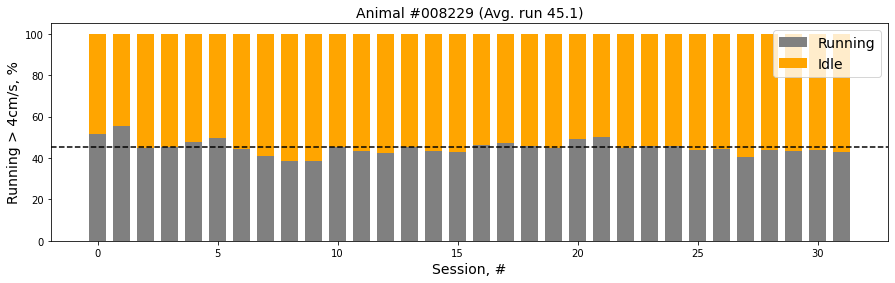

In [31]:
labels = list(sessions)
runn_cnt = ratios[:, 0]
idle_cnt = ratios[:, 1]
total = runn_cnt + idle_cnt

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 1, 1)

rects1 = ax.bar(x, 100*runn_cnt/total, width, label='Running', color='gray')
rects2 = ax.bar(x, 100*idle_cnt/total, width, bottom=100*runn_cnt/total, label='Idle', color='orange')
ax.axhline(100*round(np.mean(runn_cnt/total), 3), color='black', ls='--')
ax.legend(fontsize=14)
ax.set_title('Animal #%s (Avg. run %s)' % (animal, 100*round(np.mean(runn_cnt/total), 3)), fontsize=14)
ax.set_xlabel('Session, #', fontsize=14)
ax.set_ylabel('Running > 4cm/s, %', fontsize=14)